## Machine Learning Pipeline

In this notebook I show you the basics of training a machine learning algorithm.  For this example, we will train a Support Vector Machine, a common ML algorithm.  Through the process we will look at different hyperparameters and I will show you how to use Matplotlib to visualize different aspects of the pipeline. how to train Support Vector Machines with different kernels and use Matplotlib to plot the trained models.  For these examples we are using two datasets consisting of audio features for the task of **genre classification**. They are calculated using Marsyas, an open source software for audio analysis. The first dataset used in the code contains just two song level features (average spectral centroid and average spectral rolloff). That way the data can be visualized directly with a scatter plot. The points are colored in terms of their class membership. There are three genres each represented by a 100 tracks (instances) or points in this case. The genres are classical, jazz and metal.

In [42]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn import svm

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import seaborn as sns

from utils import make_mesh
from data.data_utils import get_doughnut_dataset

### Load Music Genre Dataset

In [55]:
target_names = ['classical', 'jazz', 'metal']
features = ['centroid', 'rolloff']
label = 'genre'

# Load dataset with only two features for visualization
X, y = datasets.load_svmlight_file("data/3genres.arff.libsvm")
X = X.toarray()
print(f'X: {X.shape}')
print(f'y: {y.shape}')

df = pd.DataFrame(data=X, columns=features)
df[label] = y

X: (300, 2)
y: (300,)


In [56]:
df[features].describe()

,centroid,rolloff
count,300.00000,300.00000
mean,0.03794,0.07660
std,0.01679,0.06707
min,0.01094,0.00411
25%,0.02533,0.02495
50%,0.03315,0.05693
75%,0.04888,0.10812
max,0.10389,0.35726


In [4]:
# Scale the data to between 0 and 1
X_minmax = MinMaxScaler().fit_transform(df[features])
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

In [5]:
X_minmax = pd.DataFrame(data=X_minmax, columns=features)
X_minmax.describe()

,centroid,rolloff
count,300.00000,300.00000
mean,0.29048,0.20527
std,0.18066,0.18991
min,0.00000,0.00000
25%,0.15485,0.05902
50%,0.23897,0.14959
75%,0.40825,0.29453
max,1.00000,1.00000


In [6]:
X_zmuv = StandardScaler().fit_transform(df[features])
# z = (x - u) / s

In [8]:
X_zmuv = pd.DataFrame(data=X_zmuv, columns=features)
X_zmuv.describe()

,centroid,rolloff
count,300.00000,300.00000
mean,0.00000,-0.00000
std,1.00167,1.00167
min,-1.61056,-1.08267
25%,-0.75203,-0.77140
50%,-0.28563,-0.29368
75%,0.65296,0.47081
max,3.93385,4.19172


In [63]:
# X, y = datasets.load_svmlight_file("data/3genres_full.arff.libsvm")
# X = X.toarray()
# print(f'X: {X.shape}')
# print(f'y: {y.shape}')

# get features and labels from original df
X = np.array(df[features])
y = np.array(df[label])

X = MinMaxScaler().fit_transform(X)

#Split the data for training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

print('Training Data')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print('Test Data')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Training Data
X: (225, 2), y: (225,)
Test Data
X: (75, 2), y: (75,)


What is the problem with splitting the data randomly? How can this be addressed?

### Create and Train SVMs with different Kernels

In [64]:
kernels = ["linear", "rbf", "poly"]
C = .3 # regularization parameter

gamma = 'scale'
models = (svm.SVC(kernel="linear", C=C), 
          svm.LinearSVC(C=C),
          svm.SVC(kernel="rbf", gamma=gamma, C=C),
          svm.SVC(kernel="poly", gamma=gamma, degree=3, C=C))

titles = ("SVC w/ Linear Kernel",
          "LinearSVC",
          "SVC w/ RBF Kernel",
          "SVC w/ 3 Degree Polynomial kernel")
#train the models
models = [clf.fit(X_train, y_train) for clf in models]

### Plot the Models

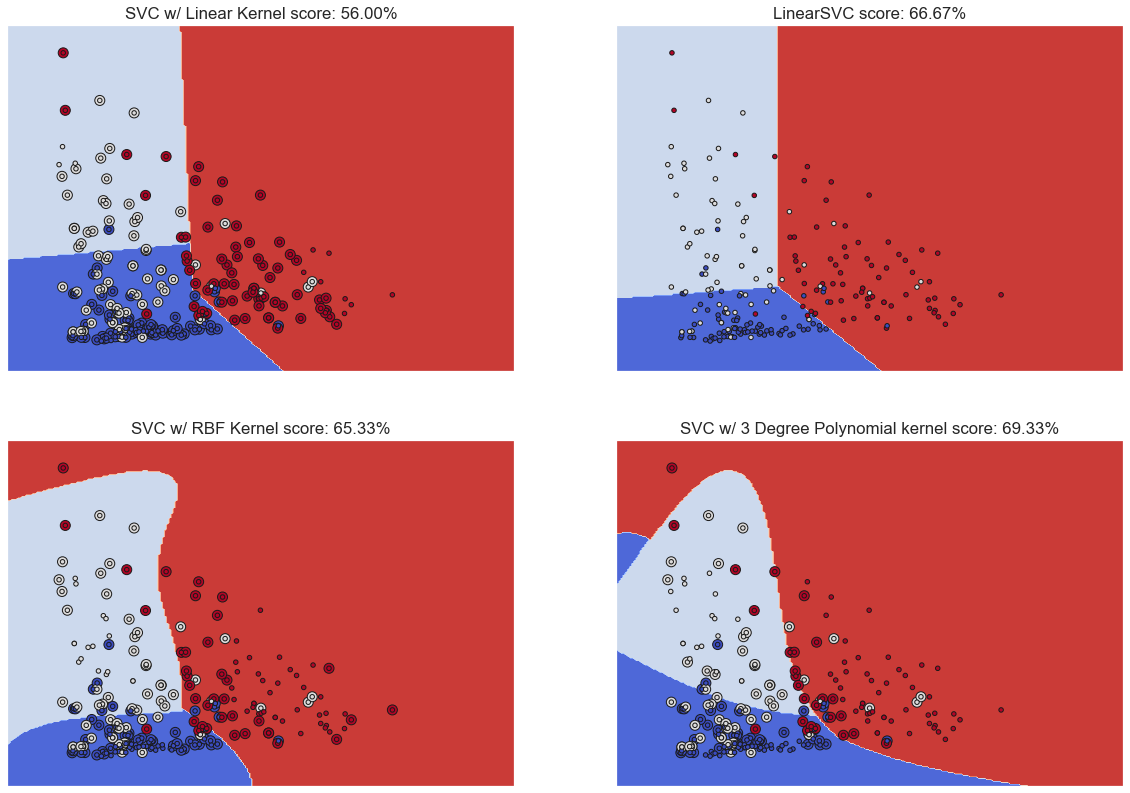

In [65]:
fig, sub = plt.subplots(2,2, figsize=(20,14))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# make mesh for plotting
xx, yy = make_mesh(X[:, 0], X[:, 1], padding=.1, h=.005)

for clf, title, ax in zip(models, titles, sub.flatten()):
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    score = clf.score(X_test, y_test)
    Z = Z.reshape(xx.shape)

    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm, zorder=11, edgecolor='k', s=20)
#     ax.scatter(X_test[:,0], X_test[:,1], c=y_test, s=50, zorder=10, edgecolor='k',cmap=plt.cm.coolwarm)

    # plot suppport samples (feature not supported in LinearSVC)
    if title != "LinearSVC":
        sv = clf.support_
        X_support = X_train[sv]
        y_support = y_train[sv]
        ax.scatter(X_support[:,0], X_support[:, 1], c=y_support, cmap=plt.cm.coolwarm, 
                   s=100, zorder=10, edgecolor='k')

    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    ax.set_title("{} score: {:.2f}%".format(title, score*100))
    ax.set_xticks(())
    ax.set_yticks(())

### Evaluation

In [66]:
from sklearn import metrics

In [67]:
for title, model in zip(titles, models):
    y_pred = model.predict(X_test)
    print(title)
    print(metrics.classification_report(y_test, y_pred))
    print()

SVC w/ Linear Kernel
              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67        24
         1.0       0.44      0.27      0.33        26
         2.0       0.65      0.60      0.63        25

    accuracy                           0.56        75
   macro avg       0.55      0.57      0.54        75
weighted avg       0.55      0.56      0.54        75


LinearSVC
              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75        24
         1.0       0.63      0.46      0.53        26
         2.0       0.67      0.72      0.69        25

    accuracy                           0.67        75
   macro avg       0.66      0.67      0.66        75
weighted avg       0.66      0.67      0.66        75


SVC w/ RBF Kernel
              precision    recall  f1-score   support

         0.0       0.69      0.75      0.72        24
         1.0       0.59      0.50      0.54        26
         2.0       0.67 

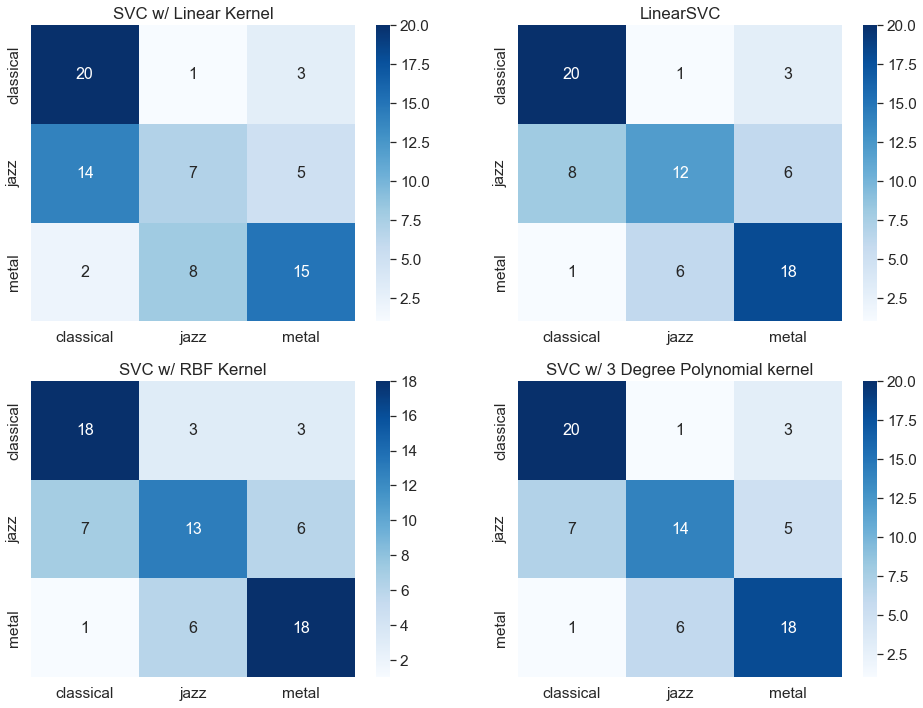

In [68]:
plt.figure(figsize=(16, 12))
for i, (title, model) in enumerate(zip(titles, models)):
    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, i+1)
    
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues',
                xticklabels=target_names, yticklabels=target_names) # font size
    plt.title(title)

### Lab Exercises

### Maximum Margin Seperating Hyperplane

In [37]:
X_blobs, y_blobs = make_blobs(n_samples=40, centers=2, random_state=6)
X_doughnut, y_doughnut, _, _ = get_doughnut_dataset()

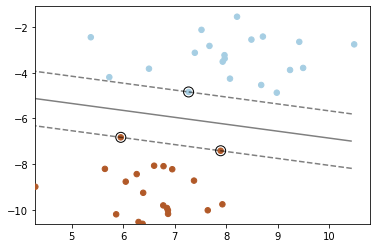

In [136]:
# X, y = X_doughnut, y_doughnut
X, y = X_blobs, y_blobs

# fit the model, don't regularize 
clf = svm.SVC(kernel='linear', C=1) ## Try with different Kernels
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired, zorder=10)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx, yy = make_mesh(X[:, 0], X[:, 1], padding=0, h=.05)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, colors='k',
           linestyles=['--', '-', '--'], zorder=11)
# # plot support vectors
sc = ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolor='k', zorder=10)